<a href="https://colab.research.google.com/github/valeriagiraldo5/software-apl/blob/main/Emotion_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/exposicion mineria/emociones.zip'

# Directory to extract the contents to
extraction_dir = '/content/extracted_emociones/'
os.makedirs(extraction_dir, exist_ok=True)

# Extract all the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Contents of '{zip_file_path}' extracted to '{extraction_dir}'")

# Now you can inspect the extracted files, for example:
# for root, dirs, files in os.walk(extraction_dir):
#     for name in files:
#         print(os.path.join(root, name))

# The original line caused an error because pd.read_csv is for CSVs, not image archives.
# dataset = pd.read_csv('/content/drive/MyDrive/exposicion mineria/emociones.zip')
# display(dataset.head())

Contents of '/content/drive/MyDrive/exposicion mineria/emociones.zip' extracted to '/content/extracted_emociones/'


# 1| Import our important libraries

In [3]:
# libraries for system
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



#import DL libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# 2| Data preprocessing

In [4]:
train_dir = '/content/extracted_emociones/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
train_df

,filepaths,labels
0,/content/extracted_emociones/train/fearful/im3...,fearful
1,/content/extracted_emociones/train/fearful/im1...,fearful
2,/content/extracted_emociones/train/fearful/im8...,fearful
3,/content/extracted_emociones/train/fearful/im3...,fearful
4,/content/extracted_emociones/train/fearful/im1...,fearful
...,...,...
28704,/content/extracted_emociones/train/disgusted/i...,disgusted
28705,/content/extracted_emociones/train/disgusted/i...,disgusted
28706,/content/extracted_emociones/train/disgusted/i...,disgusted
28707,/content/extracted_emociones/train/disgusted/i...,disgusted


In [6]:
# Generate  test data paths with labels
test_dir = '/content/extracted_emociones/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
test_df

,filepaths,labels
0,/content/extracted_emociones/test/fearful/im87...,fearful
1,/content/extracted_emociones/test/fearful/im92...,fearful
2,/content/extracted_emociones/test/fearful/im80...,fearful
3,/content/extracted_emociones/test/fearful/im93...,fearful
4,/content/extracted_emociones/test/fearful/im48...,fearful
...,...,...
7173,/content/extracted_emociones/test/disgusted/im...,disgusted
7174,/content/extracted_emociones/test/disgusted/im...,disgusted
7175,/content/extracted_emociones/test/disgusted/im...,disgusted
7176,/content/extracted_emociones/test/disgusted/im...,disgusted


# 3| Splitting the dataframe into train , valid and test

In [8]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

# 4| Image Data Generator

In [9]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 28709 validated image filenames belonging to 7 classes.
Found 4306 validated image filenames belonging to 7 classes.
Found 2872 validated image filenames belonging to 7 classes.


# 5| Showing sample from our train data

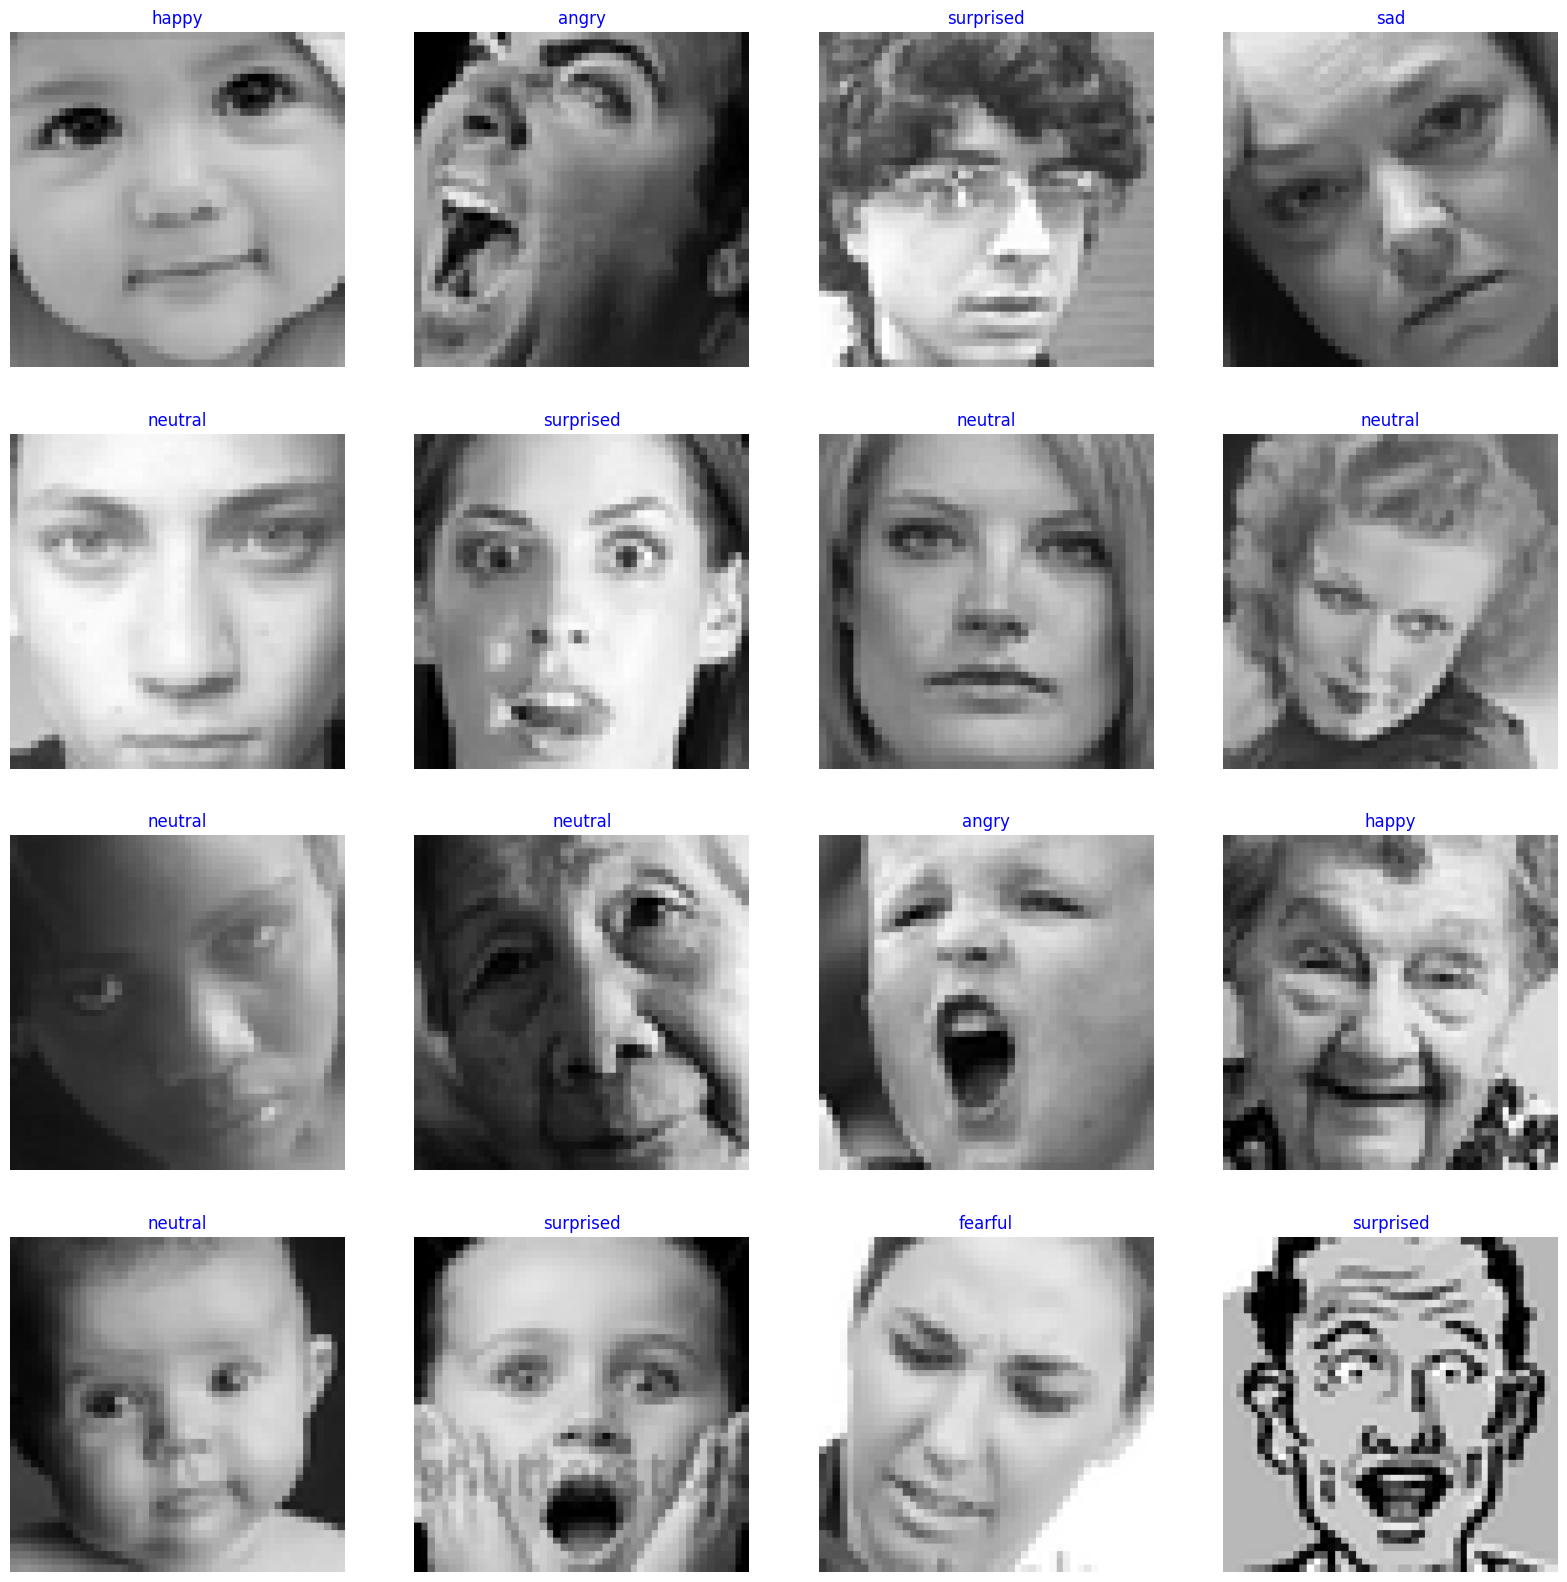

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string

# Check if train_gen produced any images
if len(g_dict) == 0:
    print("Error: train_gen did not find any classes. Cannot display sample images.")
else:
    images, labels = next(train_gen)      # get a batch size samples from the generator

    plt.figure(figsize= (20, 20))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [11]:
import os

print("Contents of /content/extracted_emociones/train:")
train_root_dir = '/content/extracted_emociones/train'

if os.path.exists(train_root_dir):
    for root, dirs, files in os.walk(train_root_dir):
        print(f"Directory: {root}")
        if files:
            print(f"  First 5 files: {files[:5]}")
        if not dirs and not files:
            print("  (Empty directory)")
else:
    print(f"Directory not found: {train_root_dir}")


Contents of /content/extracted_emociones/train:
Directory: /content/extracted_emociones/train
Directory: /content/extracted_emociones/train/fearful
  First 5 files: ['im3827.png', 'im1535.png', 'im87.png', 'im3398.png', 'im1875.png']
Directory: /content/extracted_emociones/train/surprised
  First 5 files: ['im1535.png', 'im87.png', 'im1875.png', 'im927.png', 'im2074.png']
Directory: /content/extracted_emociones/train/angry
  First 5 files: ['im3827.png', 'im1535.png', 'im87.png', 'im3398.png', 'im1875.png']
Directory: /content/extracted_emociones/train/neutral
  First 5 files: ['im3827.png', 'im4459.png', 'im1535.png', 'im87.png', 'im3398.png']
Directory: /content/extracted_emociones/train/sad
  First 5 files: ['im3827.png', 'im4459.png', 'im1535.png', 'im87.png', 'im3398.png']
Directory: /content/extracted_emociones/train/happy
  First 5 files: ['im3827.png', 'im4459.png', 'im1535.png', 'im87.png', 'im3398.png']
Directory: /content/extracted_emociones/train/disgusted
  First 5 files: 

# 6| Model structure


In [12]:
#Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,765,342 (247.06 MB)

 Trainable params: 64,449,495 (245.86 MB)

 Non-trainable params: 315,847 (1.20 MB)

# 7| Fitting our model

In [13]:
batch_size = 20   # set batch size for training
epochs =  10  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)




Epoch 1/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 1303s 591ms/step - accuracy: 0.2328 - loss: 8.0144 - val_accuracy: 0.2471 - val_loss: 2.3743
Epoch 2/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 877s 489ms/step - accuracy: 0.2517 - loss: 2.1010 - val_accuracy: 0.2471 - val_loss: 1.8562
Epoch 3/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 870s 485ms/step - accuracy: 0.2481 - loss: 1.8336 - val_accuracy: 0.2471 - val_loss: 1.8190
Epoch 4/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 876s 488ms/step - accuracy: 0.2489 - loss: 1.8179 - val_accuracy: 0.2471 - val_loss: 1.8219
Epoch 5/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 867s 483ms/step - accuracy: 0.2487 - loss: 1.8174 - val_accuracy: 0.2471 - val_loss: 1.8161
Epoch 6/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 862s 480ms/step - accuracy: 0.2494 - loss: 1.8144 - val_accuracy: 0.2471 - val_loss: 1.8140
Epoch 7/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 856s 477ms/step - accuracy: 0.2489 - loss: 1.8144 - val_accuracy: 0.2471 - val_loss: 1.8130
Epoch 8/10
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 856s 477ms/step - a

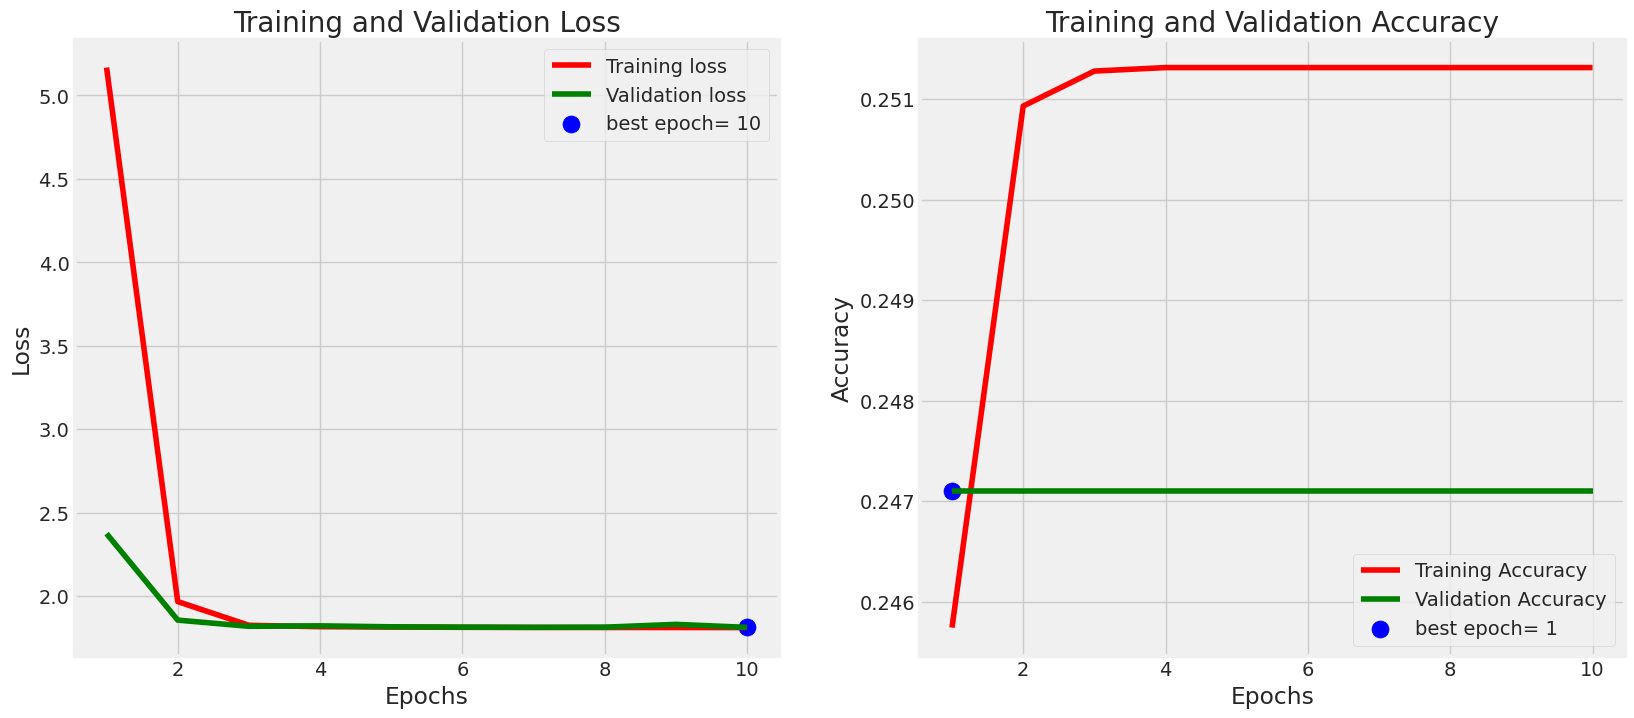

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

# 8| Evaluate the model

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

359/359 ━━━━━━━━━━━━━━━━━━━━ 48s 132ms/step - accuracy: 0.2670 - loss: 1.8035
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.2472 - loss: 1.8157 
359/359 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.2407 - loss: 1.8237
Train Loss:  1.8048036098480225
Train Accuracy:  0.2677576541900635
--------------------
Validation Loss:  1.812734842300415
Validation Accuracy:  0.24709707498550415
--------------------
Test Loss:  1.8180310726165771
Test Accuracy:  0.24721448123455048


# 9| Predictions

In [18]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

180/180 ━━━━━━━━━━━━━━━━━━━━ 60s 231ms/step


# confusion matrix and classification report

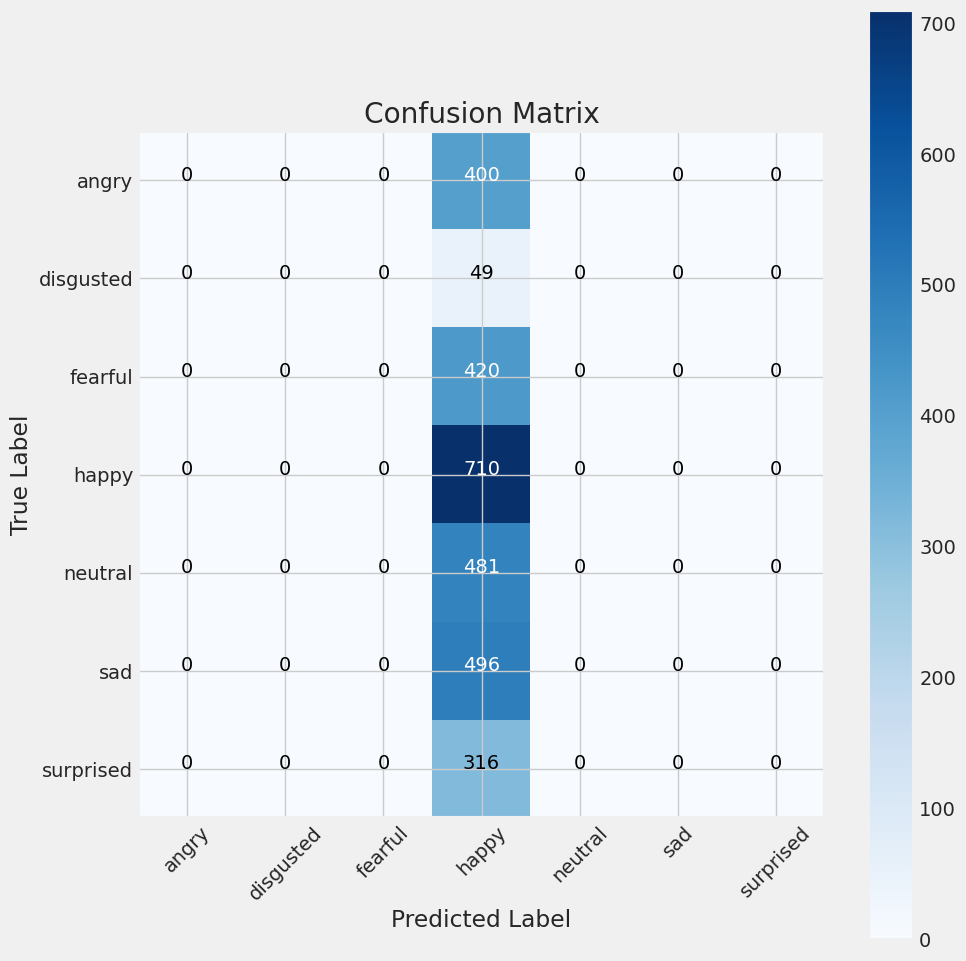

In [19]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [20]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       400
   disgusted       0.00      0.00      0.00        49
     fearful       0.00      0.00      0.00       420
       happy       0.25      1.00      0.40       710
     neutral       0.00      0.00      0.00       481
         sad       0.00      0.00      0.00       496
   surprised       0.00      0.00      0.00       316

    accuracy                           0.25      2872
   macro avg       0.04      0.14      0.06      2872
weighted avg       0.06      0.25      0.10      2872



# 10| saving the model and load it to predict

In [21]:
model.save("model.h5")

In [35]:
loaded_model = tf.keras.models.load_model('/content/model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [33]:
image_path = '/content/extracted_emociones/test/happy/im1002.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
happy


In [40]:
image_path2 = '//content/extracted_emociones/test/surprised/im1.png'
image = Image.open(image_path2)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
happy
